<a href="https://colab.research.google.com/github/neel26desai/cmpe258_transfer_learning_cv/blob/main/Transfer_Learning_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


In [ ]:
#downloading the dataset
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXEKTHQ/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXEKTHQ/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXEKTHQ/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


# Feature Extraction

In [ ]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2" # this is our base model
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423194 , -0.01190171,  0.06337537,  0.0686297 , -0.16776839,
        -0.10581177,  0.168653  , -0.04998823, -0.31148052,  0.07910344,
         0.15442258,  0.01488661,  0.03930155,  0.19772716, -0.12215477,
        -0.04120982, -0.27041087, -0.21922147,  0.26517656, -0.80739075,
         0.25833526, -0.31004202,  0.2868321 ,  0.19433866, -0.29036498,
         0.0386285 , -0.78444123, -0.04793238,  0.41102988, -0.36388886,
        -0.58034706,  0.30269453,  0.36308962, -0.15227163, -0.4439151 ,
         0.19462997,  0.19528405,  0.05666233,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201319 , -0.04418665, -0.08550781,
        -0.55847436, -0.2333639 , -0.20782956, -0.03543065, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862677,  0.7753425 , -0.07667087,
        -0.15752274,  0.01872334, -0.08169781, -0.3521876 ,  0.46373403,
        -0.08492758,  0.07166861, -0.00670818,  0.12686071, -0.19326551,
 

The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using (google/nnlm-en-dim50/2) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, 50).

For this part we will set this layer as not trainable , and then use the final embeddings for training the model.

In [ ]:
#chaining together a model which
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#make the hub layer not trainable in the model
hub_layer.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 833 (3.25 KB)
Non-trainable params: 48190600 (183.83 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [ ]:
results = model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 4s 4ms/step - loss: 0.7108 - accuracy: 0.4819
[0.7107622623443604, 0.4819200038909912]


In [ ]:
initial_epochs = 10
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=initial_epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 2s 30ms/step - loss: 0.6954 - accuracy: 0.5133 - val_loss: 0.6792 - val_accuracy: 0.5715
Epoch 2/10
30/30 [==============================] - 1s 27ms/step - loss: 0.6664 - accuracy: 0.6097 - val_loss: 0.6522 - val_accuracy: 0.6435
Epoch 3/10
30/30 [==============================] - 1s 46ms/step - loss: 0.6393 - accuracy: 0.6590 - val_loss: 0.6256 - val_accuracy: 0.6738
Epoch 4/10
30/30 [==============================] - 1s 39ms/step - loss: 0.6139 - accuracy: 0.6849 - val_loss: 0.6030 - val_accuracy: 0.6954
Epoch 5/10
30/30 [==============================] - 1s 27ms/step - loss: 0.5928 - accuracy: 0.7057 - val_loss: 0.5849 - val_accuracy: 0.7060
Epoch 6/10
30/30 [==============================] - 1s 27ms/step - loss: 0.5752 - accuracy: 0.7163 - val_loss: 0.5695 - val_accuracy: 0.7180
Epoch 7/10
30/30 [==============================] - 1s 28ms/step - loss: 0.5614 - accuracy: 0.7257 - val_loss: 0.5588 - val_accuracy: 0.7255
Epoch 8/10
30

#Transfer learning with Fine tuning

In [ ]:
#here we are allowing the weights of the trained model to be updated
hub_layer.trainable = True
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can see on comapring with the feature extraction approach, the nnumber of trainable parameters have increased drastically.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(partial_x_train,
                         partial_y_train,
                         epochs=total_epochs,
                         batch_size=512,
                         initial_epoch=len(history.epoch),
                         validation_data=(x_val,y_val))


Epoch 11/20
30/30 [==============================] - 7s 195ms/step - loss: 0.6532 - accuracy: 0.6427 - val_loss: 0.5972 - val_accuracy: 0.7392
Epoch 12/20
30/30 [==============================] - 6s 201ms/step - loss: 0.5251 - accuracy: 0.7983 - val_loss: 0.4850 - val_accuracy: 0.8060
Epoch 13/20
30/30 [==============================] - 6s 196ms/step - loss: 0.3947 - accuracy: 0.8632 - val_loss: 0.3961 - val_accuracy: 0.8416
Epoch 14/20
30/30 [==============================] - 6s 216ms/step - loss: 0.2900 - accuracy: 0.9037 - val_loss: 0.3459 - val_accuracy: 0.8578
Epoch 15/20
30/30 [==============================] - 5s 180ms/step - loss: 0.2150 - accuracy: 0.9315 - val_loss: 0.3182 - val_accuracy: 0.8677
Epoch 16/20
30/30 [==============================] - 6s 189ms/step - loss: 0.1594 - accuracy: 0.9547 - val_loss: 0.3061 - val_accuracy: 0.8732
Epoch 17/20
30/30 [==============================] - 5s 174ms/step - loss: 0.1177 - accuracy: 0.9717 - val_loss: 0.3076 - val_accuracy: 0.8729

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

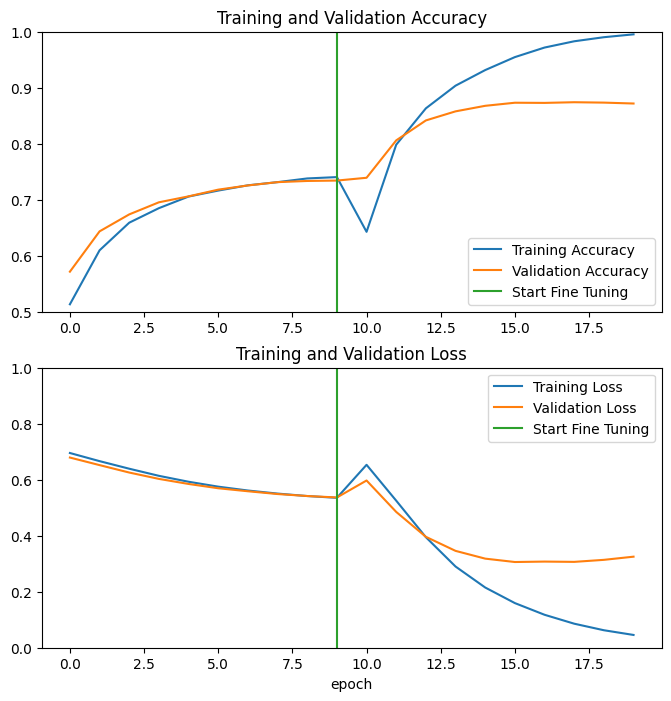

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()